In [1]:
import pandas as pd
import numpy as np
from numpy import linalg as la
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from scipy.stats import chi2_contingency
from sklearn.compose import ColumnTransformer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
# load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [2]:
# preview of the dataset 
print(train_df.info(5))
print(test_df.info(5))
print(train_df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7905 non-null   int64  
 1   N_Days         7905 non-null   int64  
 2   Drug           7905 non-null   object 
 3   Age            7905 non-null   int64  
 4   Sex            7905 non-null   object 
 5   Ascites        7905 non-null   object 
 6   Hepatomegaly   7905 non-null   object 
 7   Spiders        7905 non-null   object 
 8   Edema          7905 non-null   object 
 9   Bilirubin      7905 non-null   float64
 10  Cholesterol    7905 non-null   float64
 11  Albumin        7905 non-null   float64
 12  Copper         7905 non-null   float64
 13  Alk_Phos       7905 non-null   float64
 14  SGOT           7905 non-null   float64
 15  Tryglicerides  7905 non-null   float64
 16  Platelets      7905 non-null   float64
 17  Prothrombin    7905 non-null   float64
 18  Stage   

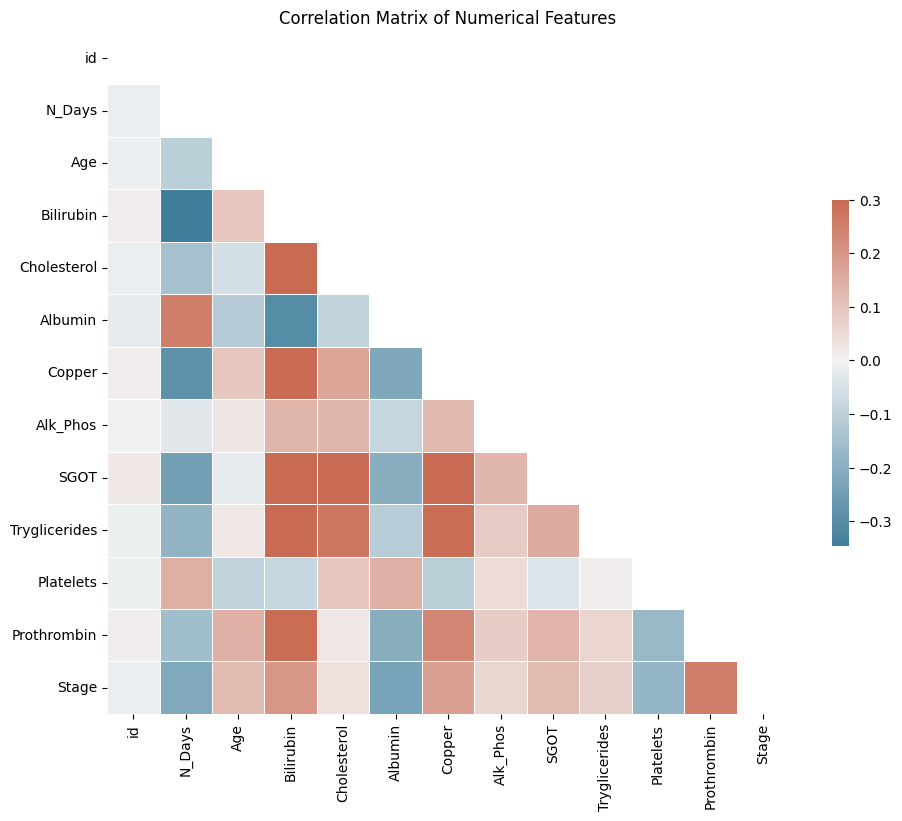

In [3]:
# Correlation matrix for numerical columns
corr = train_df.select_dtypes(include=['float64', 'int64']).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap=sns.diverging_palette(230, 20, as_cmap=True),
            vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix of Numerical Features')
plt.show()

The range of correlation isn't anywhere close to perfect

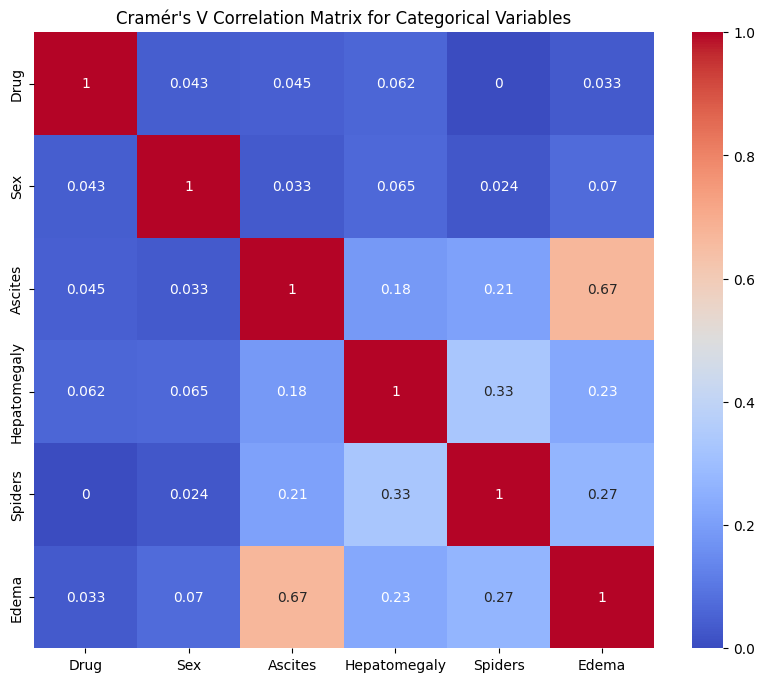

In [4]:
#Cramers V chi square test to compare categorical variables

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Categorical variables
categorical_features = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']

# Calculating Cramér's V matrix
cramers_v_matrix = pd.DataFrame(np.zeros((len(categorical_features), len(categorical_features))), index=categorical_features, columns=categorical_features)

for col1 in categorical_features:
    for col2 in categorical_features:
        cramers_v_matrix.loc[col1, col2] = cramers_v(train_df[col1], train_df[col2])

# Plotting the Cramér's V matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title("Cramér's V Correlation Matrix for Categorical Variables")
plt.show()

Ascites and Edema seem to have the strongest relationship (perhaps too much correlation)

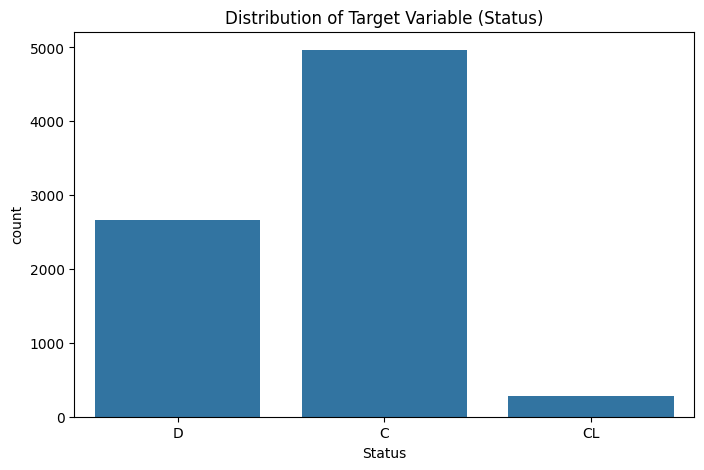

In [5]:
# Count plot for the target variable 'Status'
plt.figure(figsize=(8, 5))
sns.countplot(x='Status', data=train_df)
plt.title('Distribution of Target Variable (Status)')
plt.show()

Status has an EXTREMELY imbalanced distribution (~63% for C, ~34% D, ~3.5% for CL)

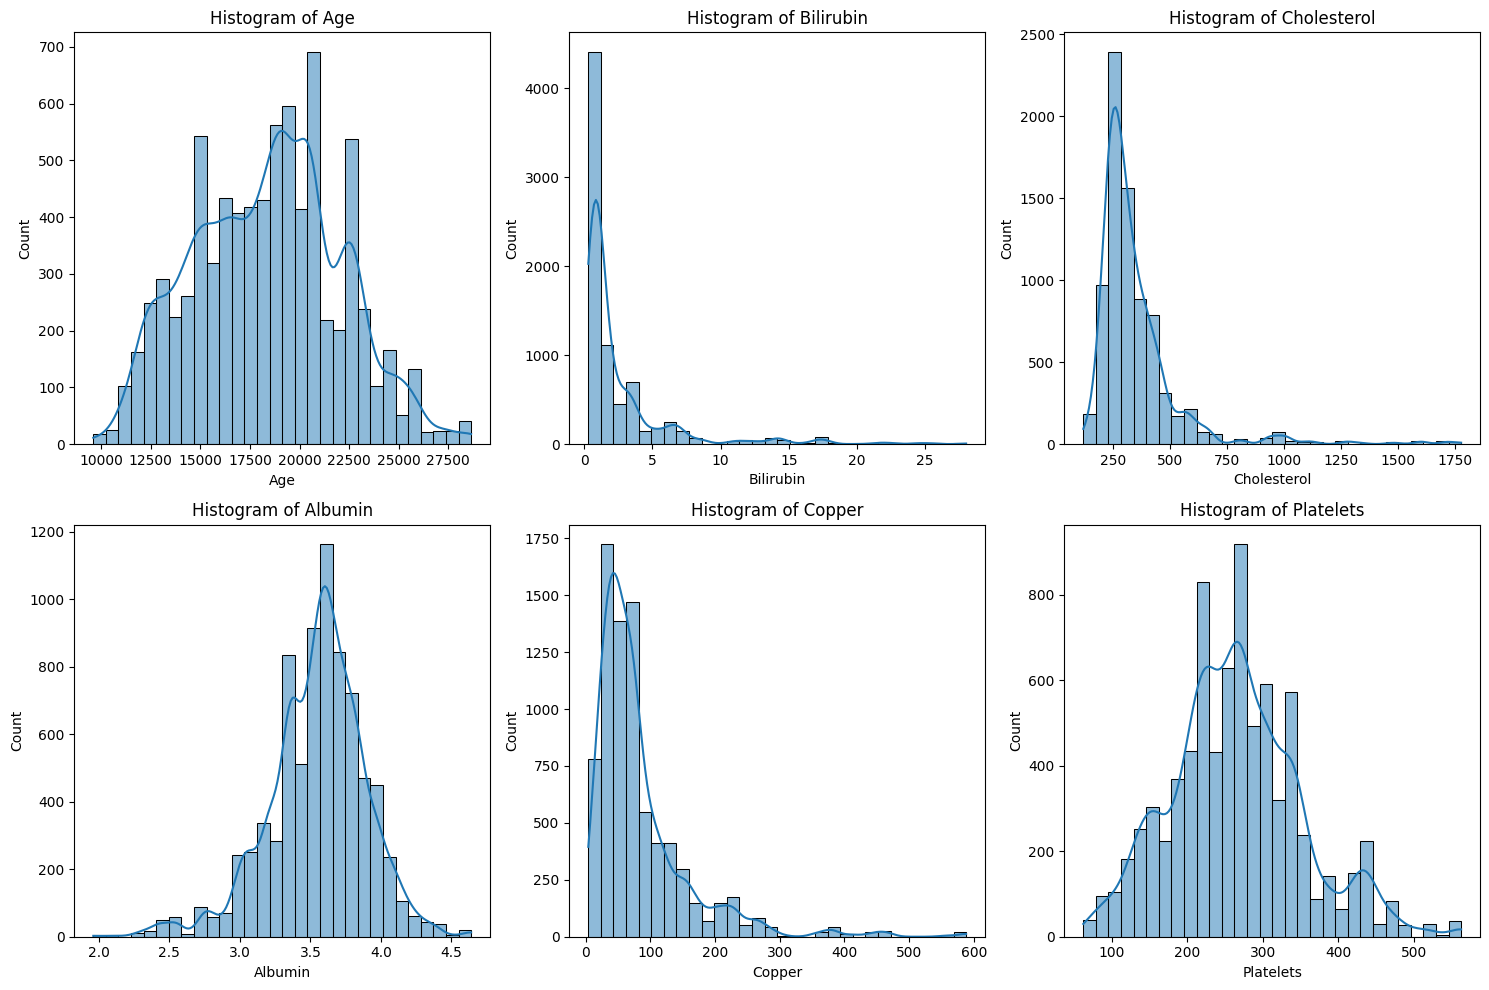

In [6]:
# Histograms for selected numerical features
features_to_plot = ['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Platelets']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.histplot(train_df[feature], kde=True, bins=30)
    plt.title(f'Histogram of {feature}')
plt.tight_layout()
plt.show()

Bilirubin, Copper, and Cholesterol is skewed right.  Platelets, Albumin, and Age are mostly normally distributed, however Albumin has a gap right below the mean, Platelets has a couple large gaps, and Age has a noticeable gap at ~21000 (57.5 years old).

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


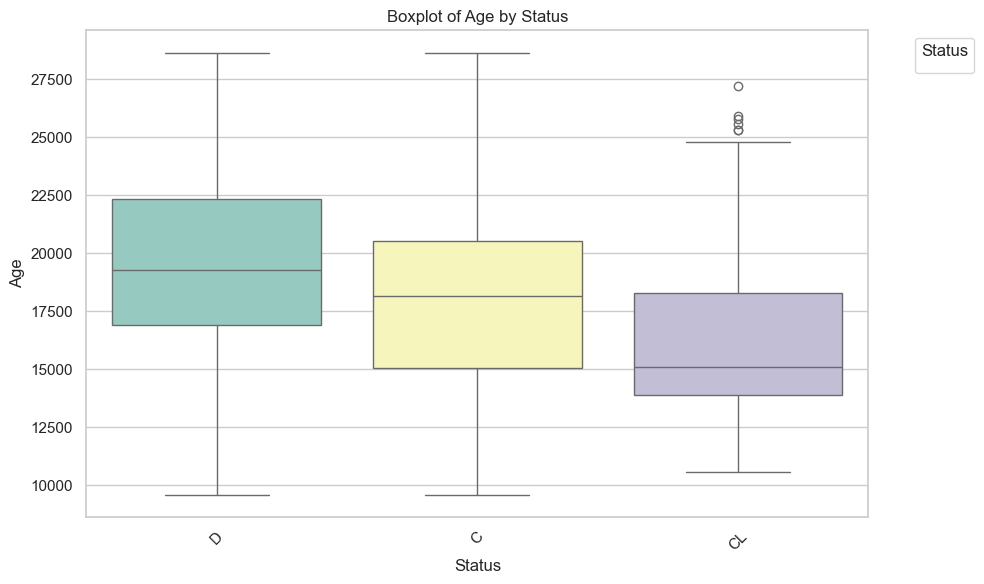

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


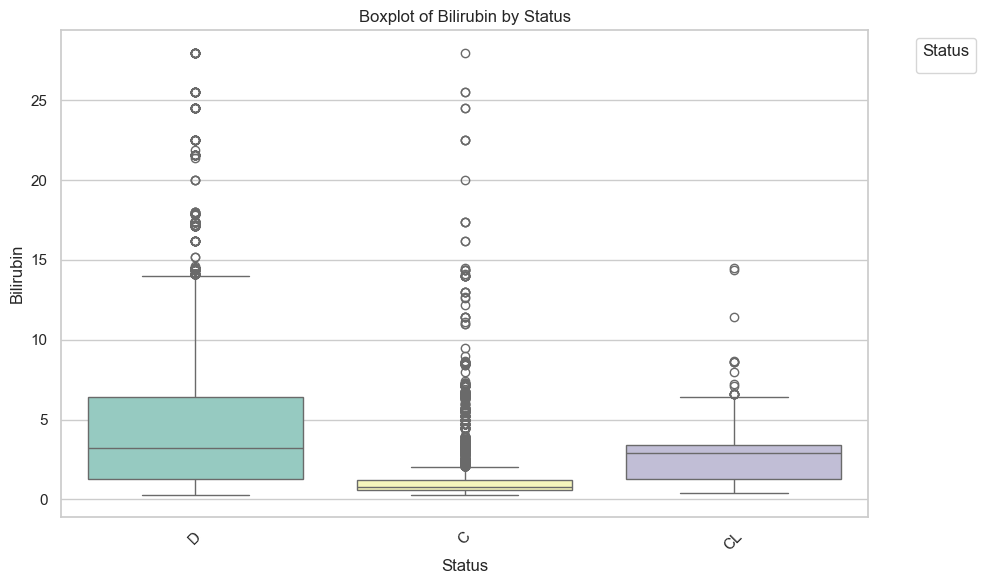

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


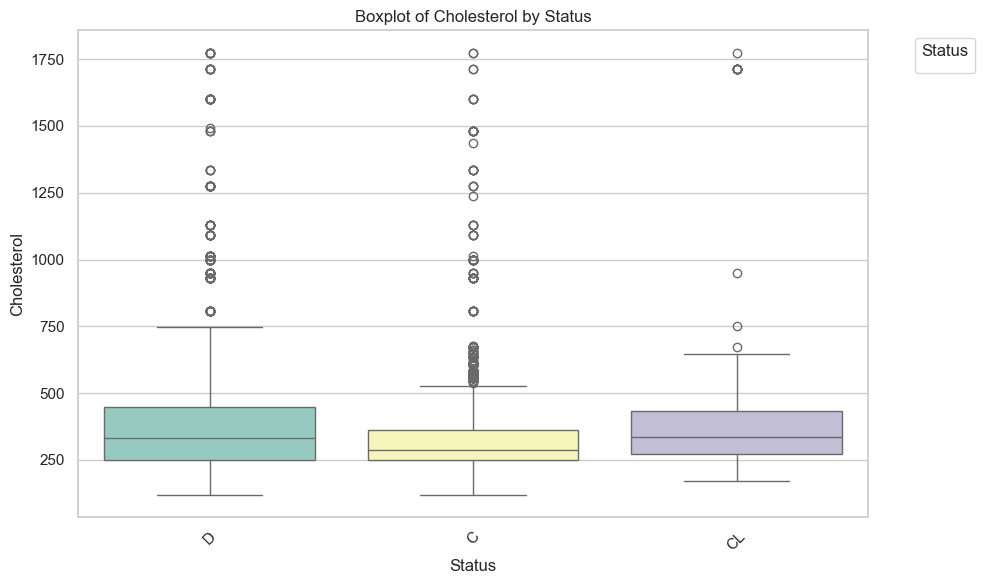

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


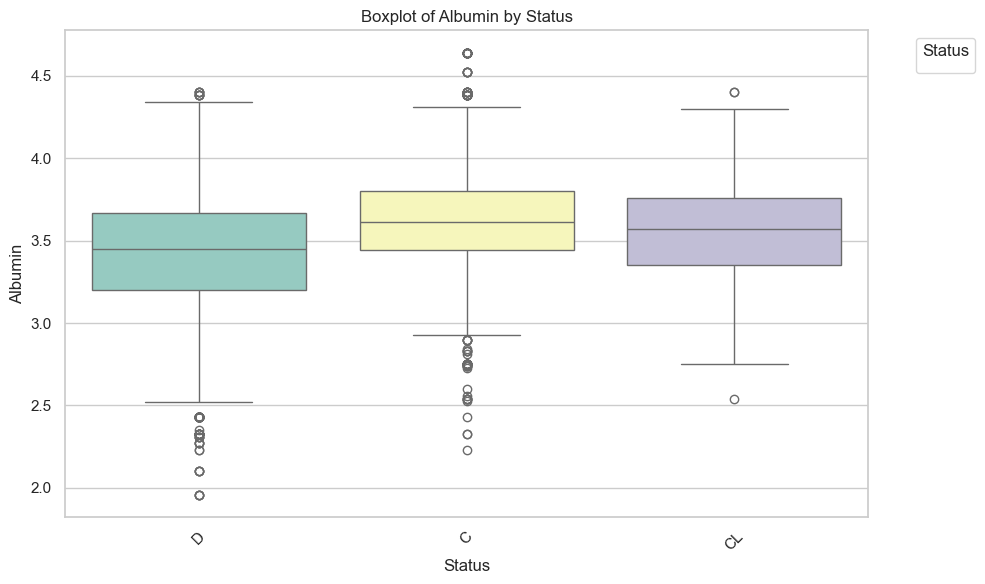

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


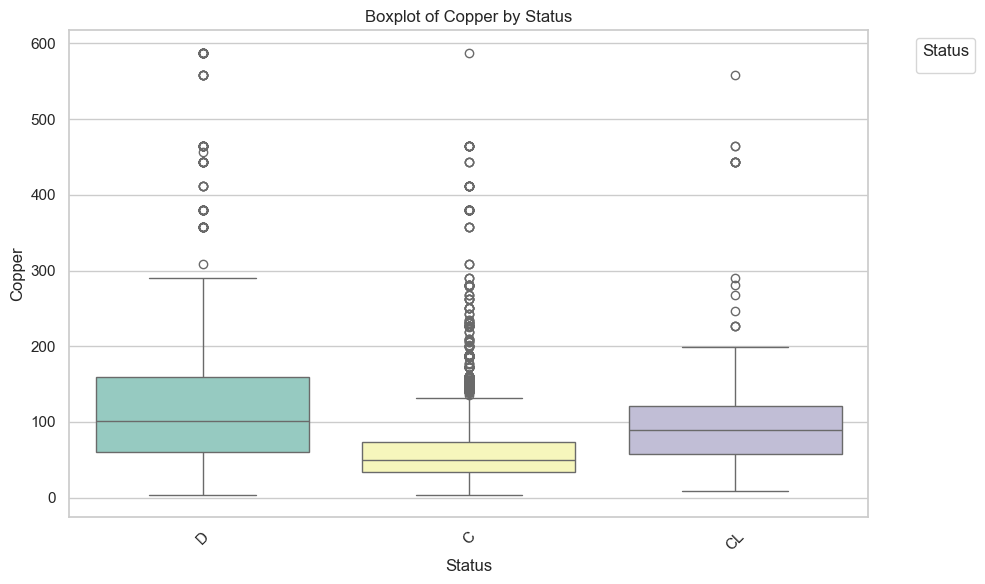

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


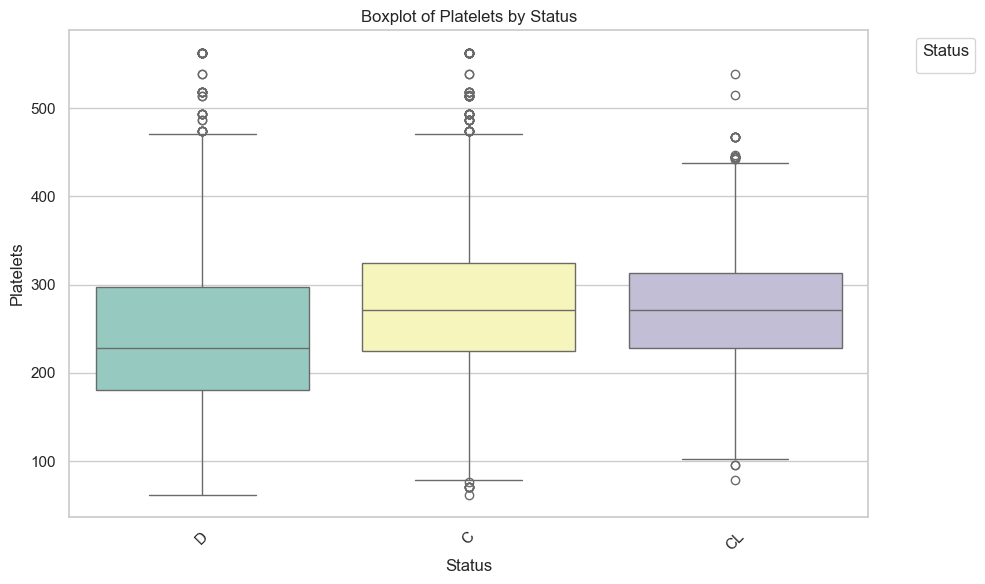

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


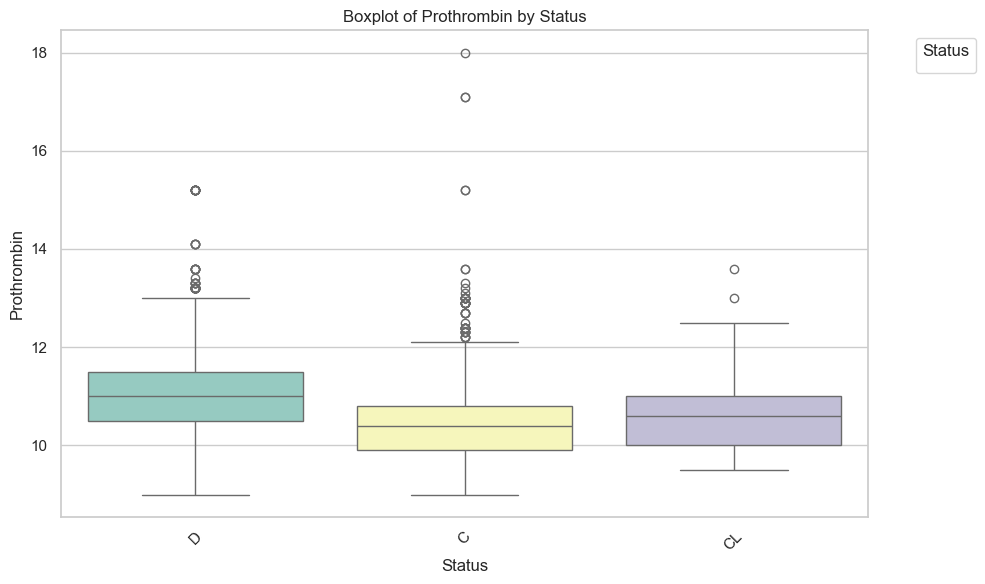

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


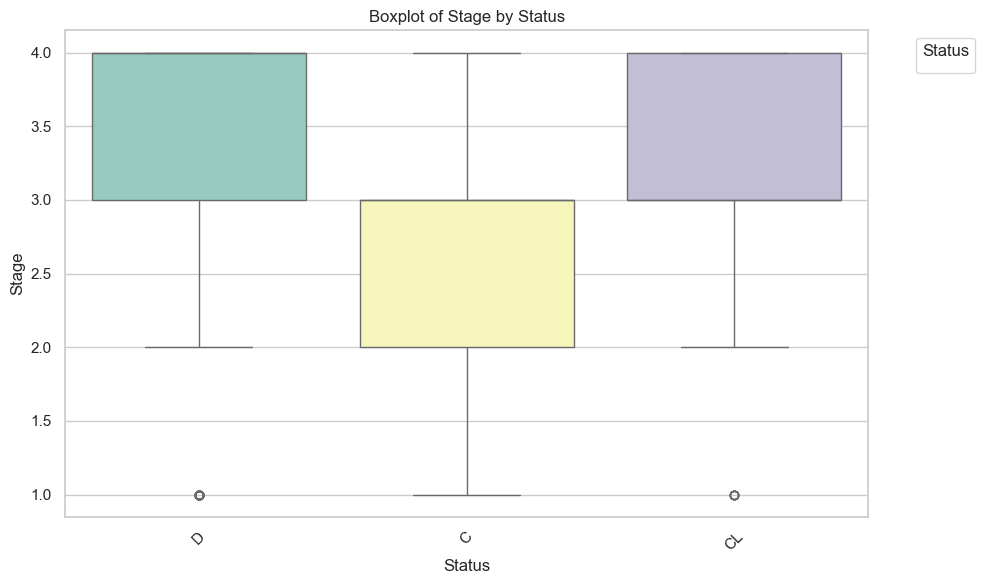

In [7]:
#boxplots shows spread, if there are a lot of outliers, status effect on them, ect
# List of numerical features 
numerical_features = ['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Platelets', 'Prothrombin', 'Stage']

# Setting the aesthetic 
sns.set(style="whitegrid")

# Creating box plots for each numerical feature against the target variable 'Status'
for col in numerical_features:
    plt.figure(figsize=(10, 6))  # Adjusting the figure size for better readability
    sns.boxplot(x='Status', y=col, hue="Status", data=train_df, palette="Set3")
    plt.title(f'Boxplot of {col} by Status')
    plt.xlabel('Status')  # Customizing the x-axis label
    plt.ylabel(col)  # Customizing the y-axis label
    plt.xticks(rotation=45)  # Rotate the x-axis labels 
    plt.legend(title='Status', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjusting legend position so it is not overlapping
    plt.tight_layout()  
    plt.show()


CL and C tend to have the most outliers.

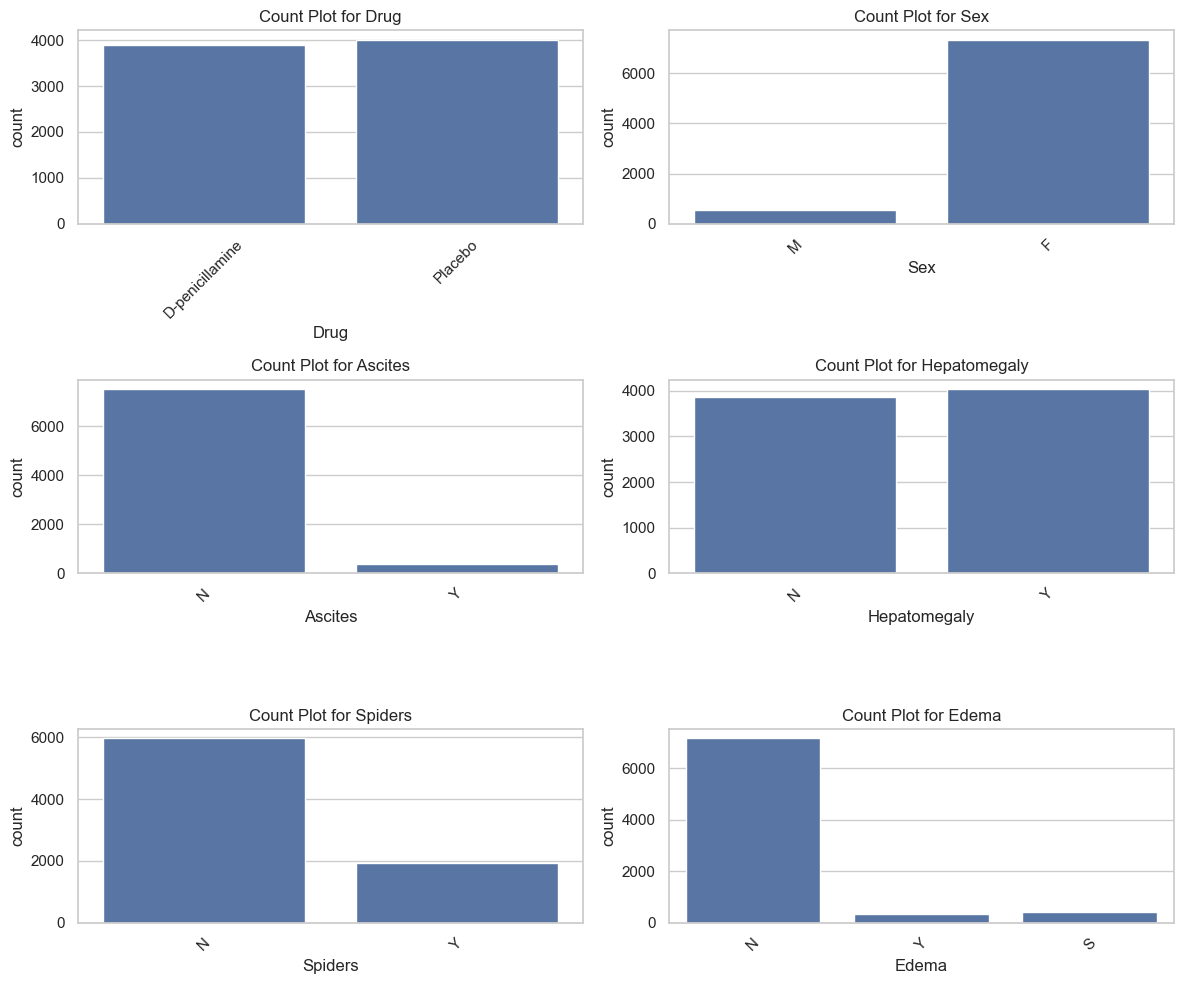

In [8]:
# Categorical variables 
categorical_features = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']

# Setting the overall aesthetics for seaborn
sns.set(style="whitegrid")

# Creating count plots for each categorical variable
plt.figure(figsize=(12, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 2, i)  
    sns.countplot(x=feature, data=train_df)
    plt.title(f'Count Plot for {feature}')
    plt.xticks(rotation=45) 

plt.tight_layout()
plt.show()

Once again, you can see the imbalance of the data when showing the count of different categories.

In [9]:
# Cleaned up encoding - Daniel
categorical_features = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
numerical_features = ['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Platelets', 'Prothrombin', 'Stage', "Alk_Phos", "SGOT", "Tryglicerides", "N_Days"]
one_hot_encoder = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()

train_results = train_df['Status']
preprocess = ColumnTransformer(
    transformers = [
        ("ID", 'passthrough', ['id']),
        ("Categorical", one_hot_encoder, categorical_features),
        ("Numerical", scaler, numerical_features)
    ]
).set_output(transform="pandas")

train_df_processed = preprocess.fit_transform(train_df)
train_df_processed.columns = train_df_processed.columns.map(lambda x : x.split("__")[1]) #Removes the unnecessary "Categorical__" or "Numerical__" prefix
test_df_processed = preprocess.transform(test_df)
test_df_processed.columns = test_df_processed.columns.map(lambda x : x.split("__")[1]) #Removes the unnecessary "Categorical__" or "Numerical__" prefix

display(train_df_processed)

,id,Drug_D-penicillamine,Drug_Placebo,Sex_F,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,...,Cholesterol,Albumin,Copper,Platelets,Prothrombin,Stage,Alk_Phos,SGOT,Tryglicerides,N_Days
0,0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,-0.176908,-0.572940,1.160785,1.472341,-1.189049,-0.037522,-0.113334,1.336304,-0.996442,-0.942430
1,1,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.068784,-0.024043,-0.275420,1.095026,0.474024,-0.037522,-0.197909,0.414968,-0.520497,0.497025
2,2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,-0.263923,0.004846,0.620561,-0.757248,1.369525,1.116605,-0.413812,0.097266,-1.243933,1.277529
3,3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,-0.484022,-0.139601,-0.341301,0.043117,0.090238,-0.037522,-0.086017,-0.887610,-0.368194,0.498852
4,4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,-0.023351,0.293739,-0.275420,0.374697,-0.037691,1.116605,-0.333965,0.224347,-0.368194,-1.135271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,7900,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,-0.212738,0.033735,-0.604825,0.900652,-0.933192,-1.191649,-0.098625,-0.728759,2.068644,-0.789802
7901,7901,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,-0.463548,-0.341826,-0.288596,0.134588,-0.805263,1.116605,-0.197909,0.561521,-0.710875,-0.491858
7902,7902,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,-0.642698,-1.035169,-0.433534,-0.745814,2.648812,-1.191649,-0.464242,-0.919380,-1.015479,-0.415087
7903,7903,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,-0.524971,-2.306298,-0.683882,-0.505705,-0.037691,1.116605,-0.427470,-1.173542,0.050637,1.420103


## Imputation

First, a copy must be made to require imputation.

In [10]:
copy_df = train_df_processed.copy()

Next, missing data must be added.

In [11]:
for col in copy_df.columns[1:]:
    copy_df.loc[copy_df.sample(frac=0.05).index, col] = np.nan

In [12]:
copy_df

,id,Drug_D-penicillamine,Drug_Placebo,Sex_F,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,...,Cholesterol,Albumin,Copper,Platelets,Prothrombin,Stage,Alk_Phos,SGOT,Tryglicerides,N_Days
0,0,1.0,NaN,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,-0.176908,-0.572940,1.160785,1.472341,-1.189049,-0.037522,-0.113334,1.336304,-0.996442,-0.942430
1,1,0.0,1.0,NaN,NaN,1.0,0.0,1.0,0.0,1.0,...,0.068784,-0.024043,-0.275420,1.095026,0.474024,-0.037522,-0.197909,NaN,-0.520497,0.497025
2,2,0.0,1.0,1.0,NaN,1.0,0.0,0.0,1.0,NaN,...,-0.263923,0.004846,0.620561,-0.757248,1.369525,1.116605,-0.413812,0.097266,-1.243933,1.277529
3,3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,NaN,1.0,...,-0.484022,-0.139601,-0.341301,0.043117,0.090238,-0.037522,-0.086017,-0.887610,-0.368194,0.498852
4,4,0.0,1.0,1.0,0.0,1.0,NaN,0.0,1.0,1.0,...,-0.023351,0.293739,-0.275420,0.374697,-0.037691,1.116605,-0.333965,0.224347,-0.368194,-1.135271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,7900,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,NaN,0.033735,-0.604825,0.900652,-0.933192,-1.191649,-0.098625,-0.728759,2.068644,-0.789802
7901,7901,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,-0.463548,-0.341826,-0.288596,0.134588,-0.805263,1.116605,-0.197909,0.561521,-0.710875,-0.491858
7902,7902,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,-0.642698,-1.035169,-0.433534,-0.745814,2.648812,-1.191649,-0.464242,-0.919380,-1.015479,-0.415087
7903,7903,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,-0.524971,-2.306298,-0.683882,-0.505705,-0.037691,1.116605,-0.427470,-1.173542,0.050637,1.420103


The three imputers used will be mean, iterative and KNN.

In [13]:
imp = [SimpleImputer(), IterativeImputer(), KNNImputer()]
out = ['','','']
diff = out
for i in range(len(imp)):
    imp[i].set_output(transform="pandas")
    imp[i].fit(copy_df)
    out[i] = imp[i].transform(copy_df)
    display(out[i])
    diff[i] = out[i] - train_df_processed
    display(diff[i])

,id,Drug_D-penicillamine,Drug_Placebo,Sex_F,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,...,Cholesterol,Albumin,Copper,Platelets,Prothrombin,Stage,Alk_Phos,SGOT,Tryglicerides,N_Days
0,0.0,1.0,0.505593,0.000000,1.000000,1.0,0.000000,1.0,0.000000,1.000000,...,-0.176908,-0.572940,1.160785,1.472341,-1.189049,-0.037522,-0.113334,1.336304,-0.996442,-0.942430
1,1.0,0.0,1.000000,0.928229,0.072037,1.0,0.000000,1.0,0.000000,1.000000,...,0.068784,-0.024043,-0.275420,1.095026,0.474024,-0.037522,-0.197909,0.002044,-0.520497,0.497025
2,2.0,0.0,1.000000,1.000000,0.072037,1.0,0.000000,0.0,1.000000,0.754727,...,-0.263923,0.004846,0.620561,-0.757248,1.369525,1.116605,-0.413812,0.097266,-1.243933,1.277529
3,3.0,0.0,1.000000,1.000000,0.000000,1.0,0.000000,1.0,0.511052,1.000000,...,-0.484022,-0.139601,-0.341301,0.043117,0.090238,-0.037522,-0.086017,-0.887610,-0.368194,0.498852
4,4.0,0.0,1.000000,1.000000,0.000000,1.0,0.048735,0.0,1.000000,1.000000,...,-0.023351,0.293739,-0.275420,0.374697,-0.037691,1.116605,-0.333965,0.224347,-0.368194,-1.135271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,7900.0,1.0,0.000000,1.000000,0.000000,1.0,0.000000,1.0,0.000000,1.000000,...,0.001975,0.033735,-0.604825,0.900652,-0.933192,-1.191649,-0.098625,-0.728759,2.068644,-0.789802
7901,7901.0,0.0,1.000000,1.000000,0.000000,1.0,0.000000,0.0,1.000000,1.000000,...,-0.463548,-0.341826,-0.288596,0.134588,-0.805263,1.116605,-0.197909,0.561521,-0.710875,-0.491858
7902,7902.0,1.0,0.000000,1.000000,0.000000,1.0,0.000000,1.0,0.000000,0.000000,...,-0.642698,-1.035169,-0.433534,-0.745814,2.648812,-1.191649,-0.464242,-0.919380,-1.015479,-0.415087
7903,7903.0,1.0,0.000000,0.000000,1.000000,1.0,0.000000,0.0,1.000000,1.000000,...,-0.524971,-2.306298,-0.683882,-0.505705,-0.037691,1.116605,-0.427470,-1.173542,0.050637,1.420103


,id,Drug_D-penicillamine,Drug_Placebo,Sex_F,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,...,Cholesterol,Albumin,Copper,Platelets,Prothrombin,Stage,Alk_Phos,SGOT,Tryglicerides,N_Days
0,0.0,0.0,0.505593,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.000000,-0.071771,0.072037,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.412924,0.0,0.0
2,0.0,0.0,0.000000,0.000000,0.072037,0.0,0.000000,0.0,0.000000,0.754727,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.511052,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.048735,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.214713,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7901,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7902,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7903,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


,id,Drug_D-penicillamine,Drug_Placebo,Sex_F,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,...,Cholesterol,Albumin,Copper,Platelets,Prothrombin,Stage,Alk_Phos,SGOT,Tryglicerides,N_Days
0,0.0,1.0,0.000823,0.000000,1.000000,1.0,0.000000,1.0,0.000000,1.000000,...,-0.176908,-0.572940,1.160785,1.472341,-1.189049,-0.037522,-0.113334,1.336304,-0.996442,-0.942430
1,1.0,0.0,1.000000,0.929305,0.070774,1.0,0.000000,1.0,0.000000,1.000000,...,0.068784,-0.024043,-0.275420,1.095026,0.474024,-0.037522,-0.197909,-0.198238,-0.520497,0.497025
2,2.0,0.0,1.000000,1.000000,0.000040,1.0,0.000000,0.0,1.000000,-0.012061,...,-0.263923,0.004846,0.620561,-0.757248,1.369525,1.116605,-0.413812,0.097266,-1.243933,1.277529
3,3.0,0.0,1.000000,1.000000,0.000000,1.0,0.000000,1.0,-0.000576,1.000000,...,-0.484022,-0.139601,-0.341301,0.043117,0.090238,-0.037522,-0.086017,-0.887610,-0.368194,0.498852
4,4.0,0.0,1.000000,1.000000,0.000000,1.0,0.000214,0.0,1.000000,1.000000,...,-0.023351,0.293739,-0.275420,0.374697,-0.037691,1.116605,-0.333965,0.224347,-0.368194,-1.135271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,7900.0,1.0,0.000000,1.000000,0.000000,1.0,0.000000,1.0,0.000000,1.000000,...,0.324075,0.033735,-0.604825,0.900652,-0.933192,-1.191649,-0.098625,-0.728759,2.068644,-0.789802
7901,7901.0,0.0,1.000000,1.000000,0.000000,1.0,0.000000,0.0,1.000000,1.000000,...,-0.463548,-0.341826,-0.288596,0.134588,-0.805263,1.116605,-0.197909,0.561521,-0.710875,-0.491858
7902,7902.0,1.0,0.000000,1.000000,0.000000,1.0,0.000000,1.0,0.000000,0.000000,...,-0.642698,-1.035169,-0.433534,-0.745814,2.648812,-1.191649,-0.464242,-0.919380,-1.015479,-0.415087
7903,7903.0,1.0,0.000000,0.000000,1.000000,1.0,0.000000,0.0,1.000000,1.000000,...,-0.524971,-2.306298,-0.683882,-0.505705,-0.037691,1.116605,-0.427470,-1.173542,0.050637,1.420103


,id,Drug_D-penicillamine,Drug_Placebo,Sex_F,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,...,Cholesterol,Albumin,Copper,Platelets,Prothrombin,Stage,Alk_Phos,SGOT,Tryglicerides,N_Days
0,0.0,0.0,0.000823,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.000000,-0.070695,0.070774,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.613206,0.0,0.0
2,0.0,0.0,0.000000,0.000000,0.000040,0.0,0.000000,0.0,0.000000,-0.012061,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,-0.000576,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000214,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.536812,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7901,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7902,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7903,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


,id,Drug_D-penicillamine,Drug_Placebo,Sex_F,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,...,Cholesterol,Albumin,Copper,Platelets,Prothrombin,Stage,Alk_Phos,SGOT,Tryglicerides,N_Days
0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,-0.176908,-0.572940,1.160785,1.472341,-1.189049,-0.037522,-0.113334,1.336304,-0.996442,-0.942430
1,1.0,0.0,1.0,0.8,0.2,1.0,0.0,1.0,0.0,1.0,...,0.068784,-0.024043,-0.275420,1.095026,0.474024,-0.037522,-0.197909,0.249763,-0.520497,0.497025
2,2.0,0.0,1.0,1.0,0.2,1.0,0.0,0.0,1.0,1.0,...,-0.263923,0.004846,0.620561,-0.757248,1.369525,1.116605,-0.413812,0.097266,-1.243933,1.277529
3,3.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.6,1.0,...,-0.484022,-0.139601,-0.341301,0.043117,0.090238,-0.037522,-0.086017,-0.887610,-0.368194,0.498852
4,4.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,-0.023351,0.293739,-0.275420,0.374697,-0.037691,1.116605,-0.333965,0.224347,-0.368194,-1.135271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,7900.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,-0.376532,0.033735,-0.604825,0.900652,-0.933192,-1.191649,-0.098625,-0.728759,2.068644,-0.789802
7901,7901.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,-0.463548,-0.341826,-0.288596,0.134588,-0.805263,1.116605,-0.197909,0.561521,-0.710875,-0.491858
7902,7902.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,-0.642698,-1.035169,-0.433534,-0.745814,2.648812,-1.191649,-0.464242,-0.919380,-1.015479,-0.415087
7903,7903.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,-0.524971,-2.306298,-0.683882,-0.505705,-0.037691,1.116605,-0.427470,-1.173542,0.050637,1.420103


,id,Drug_D-penicillamine,Drug_Placebo,Sex_F,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,...,Cholesterol,Albumin,Copper,Platelets,Prothrombin,Stage,Alk_Phos,SGOT,Tryglicerides,N_Days
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,-0.2,0.2,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.165205,0.0,0.0
2,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,1.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.163794,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7902,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


The mean and KNN imputers fail to maintain the basic property of one-hot encoding, namely that one and only one element is equal to 1, while the others are equal to 0. The mean often gives values around 0.5, while the KNN imputer is sometimes less accurate than the mean (specifically for sex). The iterative imputer, on the other hand, while sometimes giving values that are not exactly 0 or 1, gives values close to 0 or 1 that can be rounded to 0 or 1.

However, in terms of the numerical data, all three imputers perform suboptimally. However, even then, the iterative imputer seems best.

In [14]:
for i in range(3):
    print(la.norm(diff[i]))

72.75354678294339
61.36888938484489
77.76547536674803


So now, the iterative imputer will be fine-tuned.

In [15]:
imp_fine = [IterativeImputer(), IterativeImputer(estimator=BayesianRidge()), IterativeImputer(estimator=RandomForestRegressor())]
out_fine = ['','','']
diff_fine = out_fine
for i in range(len(imp_fine)):
    imp_fine[i].set_output(transform="pandas")
    imp_fine[i].fit(copy_df)
    out_fine[i] = imp_fine[i].transform(copy_df)
    diff_fine[i] = out_fine[i] - train_df_processed
    print(la.norm(diff_fine[i]))

61.36888938484489
61.36888938484489
56.39848482920808


The Bayesian Ridge estimator outputs basically the same result as the baseline IterativeImputer, but the RandomForestRegressor, while noticeably slow (taking approximately two minutes), gives a better result.